In [ ]:
pip install tensorflow

In [ ]:
pip install tensorflow-gpu


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

In [ ]:
pip install sklearn


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
import tensorflow.compat.v2.feature_column

In [ ]:
df_train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
df_test = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')

In [ ]:
y_train = df_train["survived"]
y_test = df_test['survived']

In [ ]:
df_train

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
...,...,...,...,...,...,...,...,...,...,...
622,0,male,28.0,0,0,10.5000,Second,unknown,Southampton,y
623,0,male,25.0,0,0,7.0500,Third,unknown,Southampton,y
624,1,female,19.0,0,0,30.0000,First,B,Southampton,y
625,0,female,28.0,1,2,23.4500,Third,unknown,Southampton,n


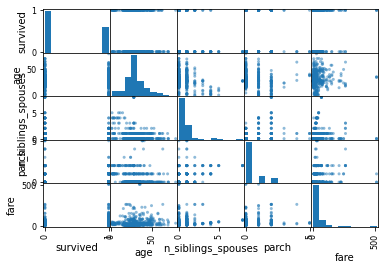

In [ ]:
pd.plotting.scatter_matrix(df_train)
plt.show()

In [ ]:
df_train.pop("survived")
df_test.pop('survived')
df_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


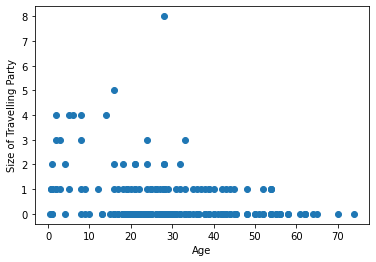

In [ ]:
plt.scatter(x=df_test["age"], y=df_test["n_siblings_spouses"])
plt.xlabel("Age")
plt.ylabel("Size of Travelling Party")
plt.show()

Check the data statistics

In [ ]:
df_train.describe()


,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


Look at Catergorical (Text) vs Discrete (Numeric) columns

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 627 non-null    object 
 1   age                 627 non-null    float64
 2   n_siblings_spouses  627 non-null    int64  
 3   parch               627 non-null    int64  
 4   fare                627 non-null    float64
 5   class               627 non-null    object 
 6   deck                627 non-null    object 
 7   embark_town         627 non-null    object 
 8   alone               627 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 44.2+ KB


Data columns are either continuous (numeric) or discrete (categorical). Tensorflow has a unique method for dealing with this. tf.feature_columns are objects that contain information concerning what datatype each column is (numeric vs categorical) and what the possible type of values there are in each column (categories). This information is required when instantiating the model. For categorical columns you pass the column name with a list of the .unique() values, for numeric columns you pass the name with a datatype of the number (dtype = int64)

In [ ]:
cat_cols = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
num_cols = ['age', 'fare']
feat_cols = []
for col_name in cat_cols:
  unique = df_train[col_name].unique()
  feat_cols.append(tf.feature_column.categorical_column_with_vocabulary_list(col_name, unique))
for col_name in num_cols:
  unique = df_train[col_name].unique()
  feat_cols.append(tf.feature_column.numeric_column(col_name, dtype=tf.float32))

feat_cols

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

The LinearClassifier model actually takes in a function argument. The function shows the Linear Model how to treat the data

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    ds = ds.batch(batch_size)
    return ds
  return input_function

train_input_fn = make_input_fn(df_train, y_train)
eval_input_fn = make_input_fn(df_test, y_test)


In [ ]:
regr = tf.estimator.LinearClassifier(feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpkxti8yz8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
regr.train(train_input_fn)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpkxti8yz8/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20...
INFO:tensorflow:Saving checkpoints for 20 into /tmp/tmpkxti8yz8/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20...
INFO:tensorflow:Loss for final step: 0.42433628.


In [ ]:
accuracy = regr.evaluate(eval_input_fn)
accuracy

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-12-27T10:31:12Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpkxti8yz8/model.ckpt-20
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.82178s
INFO:tensorflow:Finished evaluation at 2020-12-27-10:31:13
INFO:tensorflow:Saving dict for global step 20: accuracy = 0.7121212, accuracy_baseline = 0.625, auc = 0.7961739, auc_precision_recall = 0.687043, average_loss = 0.5445228, global_step = 20, label/mean = 0.375, loss = 0.54191744, precision = 0.64935064, prediction/mean = 0.38588396, recall = 0.5050505
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 20: /tmp/tmpkxti8yz8/model.ckpt-20


{'accuracy': 0.7121212,
 'accuracy_baseline': 0.625,
 'auc': 0.7961739,
 'auc_precision_recall': 0.687043,
 'average_loss': 0.5445228,
 'global_step': 20,
 'label/mean': 0.375,
 'loss': 0.54191744,
 'precision': 0.64935064,
 'prediction/mean': 0.38588396,
 'recall': 0.5050505}

In [ ]:
results = list(regr.predict(eval_input_fn))
results

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpkxti8yz8/model.ckpt-20
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'logistic': array([0.09775904], dtype=float32),
  'logits': array([-2.2223756], dtype=float32),
  'probabilities': array([0.902241  , 0.09775908], dtype=float32)},
 {'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'logistic': array([0.28367397], dtype=float32),
  'logits': array([-0.92630994], dtype=float32),
  'probabilities': array([0.71632606, 0.28367394], dtype=float32)},
 {'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'logistic': array([0.26300627], dtype=float32),
  'logits': array([-1.0304016], dtype=float32),
  'probabilities': array([0.73699373, 0.26300624], dtype=float32)

The chance of survival was listed as 0 for die and 1 for survive. In the predictions, the chance of being one or the other is listed in the dict under 'probabilities'. We can compare the probability of survival (results[n]['probabilities']) with the series corresponding to that particular record (df_test.iloc[n, :]). The chance of survival is ['probabilities][1] as 1 was encoded for survival. If we want to check the actual result we have to compare to y_test[n]

In [ ]:
print(df_test.iloc[2, :])
print(f"Probability of Survival: {results[2]['probabilities'][1]}")
if y_test[2] == 0:
  print("Subject Died")
elif y_test[2]==1:
  print("Subject Survived")
else:
  print("Incorrect Calculation")

sex                        female
age                            58
n_siblings_spouses              0
parch                           0
fare                        26.55
class                       First
deck                            C
embark_town           Southampton
alone                           y
Name: 2, dtype: object
Probability of Survival: 0.2630062401294708
Subject Survived


Direct comparison of the accuracy of a model like this is problematic as the target is an integer encoding survival (or lack of survival), and the output of the model is the probabilty of survival based on multiple factors (multiple regression). However, it can be accomplished with a bit of data handling. We can take the probability of survival and convert it to int then compare to the original target data, then calculate percentage correct results

In [ ]:
probabilities = [int(np.round(item['probabilities'][1])) for item in results] #index out the probability of survival and cast as int
total_num = len(y_test)
good_prediction = 0
for index, item in enumerate(probabilities):
  if item == y_test[index]:
    good_prediction += 1

prediction_accuracy = (good_prediction/total_num*100)
print(f"The Prediction Accuracy of the Model: {prediction_accuracy:.2f} %")


The Prediction Accuracy of the Model: 71.21 %


We can also create models in sklearn using sklearn.linear_models

In [ ]:
from sklearn.linear_model import LinearRegression


sklearn requires the data to be numerically encoded. pd.get_dummies() is a usefule one hot encoder for dataframes

In [ ]:
y_vals = pd.concat([y_train, y_test])
y_vals.reset_index(drop=True, inplace=True)
x_vals = pd.concat([df_train, df_test])
x_vals.reset_index(drop=True, inplace=True)


In [ ]:
full_data = pd.concat([x_vals, y_vals], axis=1)
full_data.head(2)

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone,survived
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n,0
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n,1


In [ ]:
full_data_numeric = pd.get_dummies(data=full_data, columns = ['sex', 'class', 'deck', 'embark_town', 'alone'])
full_data_numeric.head(2)

,age,n_siblings_spouses,parch,fare,survived,sex_female,sex_male,class_First,class_Second,class_Third,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_unknown,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_unknown,alone_n,alone_y
0,22.0,1,0,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1,38.0,1,0,71.2833,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
y = full_data_numeric.pop('survived')

In [ ]:
x = full_data_numeric
x.head(2)

,age,n_siblings_spouses,parch,fare,sex_female,sex_male,class_First,class_Second,class_Third,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_unknown,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_unknown,alone_n,alone_y
0,22.0,1,0,7.2500,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1,38.0,1,0,71.2833,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0


Split the dataset for training and testing using sklearn.model_selection.train_test_split()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True)

Instantiate the linear and train/fit the linear model

In [ ]:
regr = LinearRegression()
regr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
coefficient = regr.coef_[0]
intercept = regr.intercept_
score = regr.score(x_train, y_train)
print(f"coeffienct :{coefficient:.2f}")
print(f"intercept : {intercept:.2f}")
print(f"r-squared : {score:.2f}")

coeffienct :-0.01
intercept : 0.90
r-squared : 0.49


With sklearn checking accuracy is easier


In [ ]:
pred = regr.predict(x_test)
rounded = np.round(pred)
survival_prediction = [int(item) for item in rounded] 
y_pred = [item for item in y_test]
num = len(x_test)
correct_pred = 0

for index, item in enumerate(survival_prediction):
  if item == y_pred[index]:
    correct_pred += 1

accuracy = correct_pred/num *100
print(f"Accuracy: {accuracy:.2f}%")



Accuracy: 74.92%


835    1
675    1
559    1
143    1
656    1
      ..
29     1
810    1
274    1
413    0
518    0
Name: survived, Length: 295, dtype: int64


Tensorflow model accuracy was 71%, sklearn model was 74%, so basically the same. Sklearn is easier in application, and has functions for train test split, validation and doesnt require so much data transformation to train, fit and predict from a model